# Task 1: Finding rectangles

In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, Markdown

%matplotlib inline

# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 1, 4))

**Here is an example of the training data:**

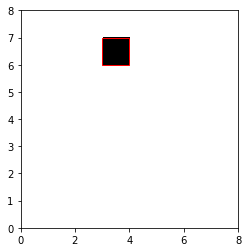

In [12]:
display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [2]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## Task 1a
Construct a Pytorch model that resembles the Keras one in the original blog post, i.e. have a fully connected, hidden layer with 200 neurons, ReLU nonlinearity and dropout rate of 20%.

In [3]:
D_in = 64
H = 200
D_out = 4
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(H, D_out)
)

In [4]:
optimizer = torch.optim.Adadelta(model.parameters())
loss_fn = torch.nn.MSELoss(size_average=False)

In [5]:
inputs = Variable(torch.FloatTensor(train_X))
labels = Variable(torch.FloatTensor(train_y))

In [6]:
phase = 'train'
running_loss = 0.0
running_corrects = 0

loss_record = []
for epoch in range(30):
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn(outputs, labels)

    if phase == 'train':
        loss.backward()
        optimizer.step()

    running_loss += loss.data[0] * inputs.size(0)
    epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
    loss_record.append(epoch_loss)

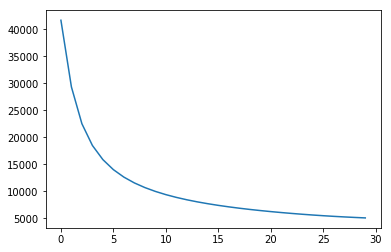

In [7]:
plt.plot(loss_record)

In [8]:
# Predict bounding boxes on the test images.
pred_y = model(Variable(torch.Tensor(test_X)))
pred_bboxes = pred_y.data * img_size
pred_bboxes = pred_bboxes.numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [9]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.12694938409229842

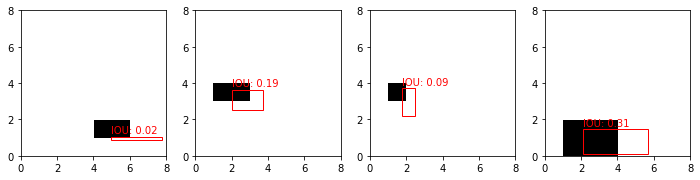

In [10]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

## Task 1b:
Move the computation that is currently done on the CPU over to the GPU using CUDA and increase the number of epochs. Improve the training setup until you reach an IOU of above 0.6.
You can make the changes that move computation to the GPU directly in the cells above.

In [39]:
D_in = 64
H = 200
D_out = 4
use_gpu = torch.cuda.is_available()
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(H, D_out),
    nn.ReLU()
)

if use_gpu:
    model = model.cuda()

In [40]:
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss(size_average=False)

In [41]:
inputs = Variable(torch.cuda.FloatTensor(train_X))
labels = Variable(torch.cuda.FloatTensor(train_y))

In [42]:
phase = 'train'
running_loss = 0.0
running_corrects = 0

loss_record = []
for epoch in range(5000):
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn(outputs, labels)

    if phase == 'train':
        loss.backward()
        optimizer.step()

    running_loss += loss.data[0] * inputs.size(0)
    epoch_loss = running_loss / inputs.shape[0] / (epoch+1)
    loss_record.append(epoch_loss)

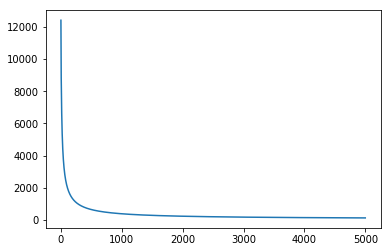

In [43]:
plt.plot(loss_record)

In [44]:
# Predict bounding boxes on the test images.
pred_y = model(Variable(torch.cuda.FloatTensor(test_X)))
pred_bboxes = pred_y.data * img_size
pred_bboxes = pred_bboxes.cpu().numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [45]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.75791168398948316

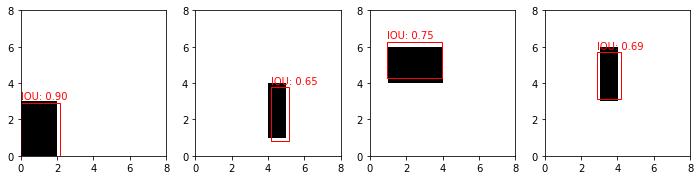

In [46]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

# Task 2: Use a pretrained model

As mentioned in class deep learning systems are hardly ever developed from scratch, but usually work by refining existing solutions to similar problems. For the following task, we'll work through the 
[Transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), which also provides a ready-made jupyter notebook.

 1. Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.
 2. Perform your own training with the provided setup.
 3. Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type.
 4. Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network) that can detect one out of 1000 classes.

In [2]:
# License: BSD
# Original Author: Sasank Chilamkurthy
# Customized by: Muhammad Raihan Muhaimin

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import json, requests

plt.ion()   # interactive mode

The following steps requires to download the data from [here]('https://download.pytorch.org/tutorial/hymenoptera_data.zip') and extract it to the current directory. We also put our custom images for classifying with a pretrained model.

### Download the notebook and get it to run in your environment. 

This also involves downloading the bees and ants dataset and loading my own picture in dataset

In [3]:
data_dir = 'hymenoptera_data'
if not os.path.exists(data_dir):
    raise Exception('Please download and unzip the hymenoptera_data inside home directory! https://download.pytorch.org/tutorial/hymenoptera_data.zip')
else:
    # Download custom images
    custom_data_dir = data_dir+'/'+'custom_data/lizard'
    os.makedirs(custom_data_dir, exist_ok=True)
    image_url = 'https://thumb1.shutterstock.com/display_pic_with_logo/264820/264820,1255811865,3/stock-photo-vertical-portrait-of-a-royal-bengal-tiger-39057226.jpg'
    with open(custom_data_dir+'/user_image.jpg', 'wb') as handler:
        img_data = requests.get(image_url).content
        handler.write(img_data)

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'custom_data': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'custom_data']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'custom_data']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'custom_data']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

Method for visualizing image inside matplotlib

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


### Perform your own training with the provided setup.

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an Learning Rate scheduler object from
``torch.optim.lr_scheduler``.

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images

In [7]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

### Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type.

In [32]:
# Try out VGG

model_conv = torchvision.models.vgg19(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

num_layers  = len(model_conv.classifier)
model_in_ftrs = model_conv.classifier[num_layers - 1].in_features
    
model_conv.classifier = nn.Sequential(*list(model_conv.classifier.children())[:-1] +
                     [nn.Linear(model_in_ftrs,2)])
if use_gpu:
    model_conv = model_conv.cuda()
model_conv, type(model_conv)    

(VGG(
   (features): Sequential(
     (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU(inplace)
     (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU(inplace)
     (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
     (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (6): ReLU(inplace)
     (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): ReLU(inplace)
     (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
     (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace)
     (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (13): ReLU(inplace)
     (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (15): ReLU(inplace)
     (16): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (17): ReLU(inplac

In [9]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier[num_layers-1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2734 Acc: 0.8893
val Loss: 0.0845 Acc: 0.9673

Epoch 1/24
----------
train Loss: 0.2360 Acc: 0.9344
val Loss: 0.0795 Acc: 0.9804

Epoch 2/24
----------
train Loss: 0.1372 Acc: 0.9467
val Loss: 0.0803 Acc: 0.9673

Epoch 3/24
----------
train Loss: 0.0675 Acc: 0.9754
val Loss: 0.0972 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.1822 Acc: 0.9344
val Loss: 0.0903 Acc: 0.9673

Epoch 5/24
----------
train Loss: 0.1441 Acc: 0.9344
val Loss: 0.1114 Acc: 0.9673

Epoch 6/24
----------
train Loss: 0.0958 Acc: 0.9467
val Loss: 0.0658 Acc: 0.9804

Epoch 7/24
----------
train Loss: 0.0957 Acc: 0.9795
val Loss: 0.0618 Acc: 0.9673

Epoch 8/24
----------
train Loss: 0.1453 Acc: 0.9508
val Loss: 0.0683 Acc: 0.9804

Epoch 9/24
----------
train Loss: 0.1095 Acc: 0.9631
val Loss: 0.0665 Acc: 0.9739

Epoch 10/24
----------
train Loss: 0.0851 Acc: 0.9672
val Loss: 0.0727 Acc: 0.9804

Epoch 11/24
----------
train Loss: 0.1045 Acc: 0.9631
val Loss: 0.0756 Acc: 0.9804

Ep

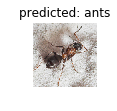

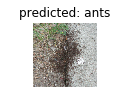

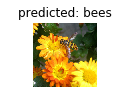

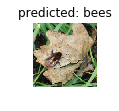

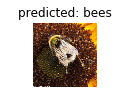

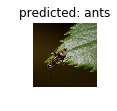

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [33]:
# Using alexnet

model_conv = torchvision.models.alexnet(pretrained=True)
if use_gpu:
    model_conv = model_conv.cuda()


for param in model_conv.parameters():
    param.requires_grad = False

num_layers  = len(model_conv.classifier)
model_in_ftrs = model_conv.classifier[num_layers - 1].in_features
    
    
model_conv.classifier = nn.Sequential(*list(model_conv.classifier.children())[:-1] +
                     [nn.Linear(model_in_ftrs,2)])

if use_gpu:
    model_conv = model_conv.cuda()
model_conv, type(model_conv)         

(AlexNet(
   (features): Sequential(
     (0): Conv2d (3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
     (1): ReLU(inplace)
     (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
     (3): Conv2d (64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (4): ReLU(inplace)
     (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
     (6): Conv2d (192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): ReLU(inplace)
     (8): Conv2d (384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (9): ReLU(inplace)
     (10): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): ReLU(inplace)
     (12): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))
   )
   (classifier): Sequential(
     (0): Dropout(p=0.5)
     (1): Linear(in_features=9216, out_features=4096)
     (2): ReLU(inplace)
     (3): Dropout(p=0.5)
     (4): Linear(in_features=4096, out_features=4096)
     (5): ReLU(

In [34]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier[num_layers-1].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.

In [35]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7743 Acc: 0.7910
val Loss: 0.6989 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.7420 Acc: 0.8770
val Loss: 1.0374 Acc: 0.8562

Epoch 2/24
----------
train Loss: 0.5194 Acc: 0.9262
val Loss: 0.5758 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.2831 Acc: 0.9303
val Loss: 0.6163 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.3953 Acc: 0.9221
val Loss: 0.8096 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4110 Acc: 0.9016
val Loss: 0.9777 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.2972 Acc: 0.9549
val Loss: 0.8349 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.2030 Acc: 0.9590
val Loss: 0.7799 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.2633 Acc: 0.9549
val Loss: 0.7529 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3755 Acc: 0.9385
val Loss: 0.7575 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.1899 Acc: 0.9590
val Loss: 0.7441 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2542 Acc: 0.9590
val Loss: 0.7189 Acc: 0.9085

Ep

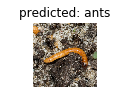

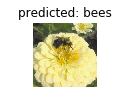

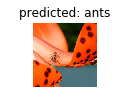

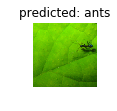

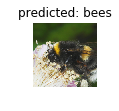

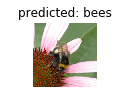

In [37]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network) that can detect one out of 1000 classes.

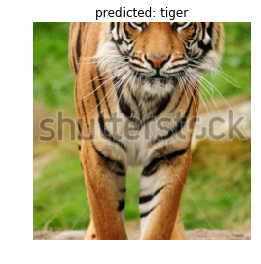

In [29]:
r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
class_names = r.json()

def visualize_custom_data_pred(model, num_images=1):
    if use_gpu:
        model = model.cuda()
    images_so_far = 0
    fig = plt.figure()
   
    for i, data in enumerate(dataloaders['custom_data']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            
            images_so_far += 1
            ax = plt.subplot(num_images, images_so_far, num_images)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[str(preds[j])][1]))
            imshow(inputs.cpu().data[j])

            
visualize_custom_data_pred(torchvision.models.vgg19(pretrained=True))

plt.ioff()
plt.show()